In [96]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt

In [97]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 10.5, 51
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 100000
CHUNK_SIZE_S = 50000

In [98]:
def process_dataarray(da_o3):
    
    time_chunks = CHUNK_SIZE_L if da_o3.size > 500000 else CHUNK_SIZE_S
    
    if isinstance(da_o3.data, da.Array):
        da_o3 = da_o3.chunk({'time': time_chunks})
    else:
        da_o3.data = da.from_array(da_o3.data, 
                                          chunks= time_chunks)
    
    return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [99]:
import OSIRIS.OSIRIS_helper as OSIRIS
import ACEFTS.ACEFTS_helper as ACE

In [100]:
daL = OSIRIS.get_column_DU(ALT_MIN, ALT_MAX)
daS = ACE.get_column_DU(ALT_MIN, ALT_MAX)

In [101]:
daL = process_dataarray(daL)
daS = process_dataarray(daS)

In [102]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [103]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)
S_nan_filter = ~np.isnan(o3S_arr)
o3S_arr = o3S_arr[S_nan_filter]
tL = daL.time.values.astype('datetime64[ns]')
tS = daS.time.values.astype('datetime64[ns]')
tS = tS[S_nan_filter]
latL = daL.latitude.values
lonL = daL.longitude.values
latS = daS.latitude.values
latS = latS[S_nan_filter]
lonS = daS.longitude.values
lonS = lonS[S_nan_filter]


tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max) & ~np.isnan(o3L_arr)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]

client.close()
cluster.close()
del o3L_arr, latL, lonL
gc.collect()

53871

In [104]:
tL_ns = tL_filtered.astype(np.int64)
tS_ns = tS.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3S_coincidences = []
o3L_coincidences = []
days_of_year = []
time = []
measurement_times_dt = []
measurement_times = []

time_bins = np.arange(tL_ns.min(), tL_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tL_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tS_ns, latS, lonS)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tS)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tL_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latL_filtered[time_valid_indices]
    candidate_lons = lonL_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3L_coincidences.append(o3L_arr_filtered[best_L_idx])
        o3S_coincidences.append(o3S_arr[s_idx])
        processed_pairs += 1

        dt = tL_ns[best_L_idx]
        dt = dt.astype('datetime64[ns]')
        day_of_year = ((dt - dt.astype('datetime64[Y]'))   // np.timedelta64(1, 'D')) + 1
        time.append(dt)

        days_of_year.append(day_of_year)
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE-FTS point {s_idx}...")

        measurement_times.append(tS_ns[s_idx])
        measurement_times_dt.append(tS[s_idx])

o3S_coincidences = np.vstack(o3S_coincidences)
o3L_coincidences = np.vstack(o3L_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/89867...
Found 1000 pairs at ACE-FTS point 8488...
Processing ACE-FTS point 10000/89867...
Found 2000 pairs at ACE-FTS point 13372...
Found 3000 pairs at ACE-FTS point 17212...
Processing ACE-FTS point 20000/89867...
Found 4000 pairs at ACE-FTS point 22111...
Found 5000 pairs at ACE-FTS point 27873...
Processing ACE-FTS point 30000/89867...
Found 6000 pairs at ACE-FTS point 32713...
Processing ACE-FTS point 40000/89867...
Found 7000 pairs at ACE-FTS point 45056...
Processing ACE-FTS point 50000/89867...
Found 8000 pairs at ACE-FTS point 58767...
Processing ACE-FTS point 60000/89867...
Processing ACE-FTS point 70000/89867...
Processing ACE-FTS point 80000/89867...
Found 9000 pairs at ACE-FTS point 82051...
Total coincidences found: 9256


In [105]:
# using 8km: before:  15551, without taking into account nan, 9256 after

In [106]:
# o3S_coincidences[o3S_coincidences == 0] = np.nan
# o3L_coincidences[o3L_coincidences == 0] = np.nan
o3L_coincidences[o3L_coincidences == np.float32("inf")] = np.nan
o3S_coincidences[o3S_coincidences == np.float32("inf")] = np.nan

In [107]:
rel, abs, raw = compute_diffs(o3L_coincidences, o3S_coincidences)

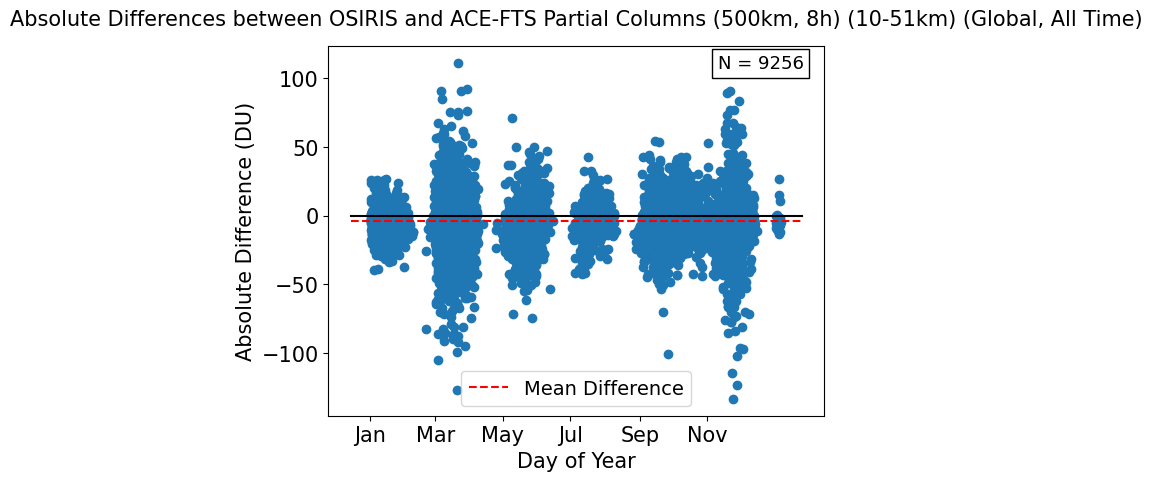

In [108]:
plt.scatter(days_of_year, raw)
raw_mean = np.nanmean(raw)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [raw_mean, raw_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Absolute Difference (DU)")

plt.title("Absolute Differences between OSIRIS and ACE-FTS Partial Columns" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)
locs  = np.array([0,  58, 118, 178, 240, 300])
ticks = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]
plt.xticks(locs, ticks)

plt.legend(fontsize=14)
fig = plt.gcf()
axes = plt.gca()

plt.text(0.785, 0.94, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

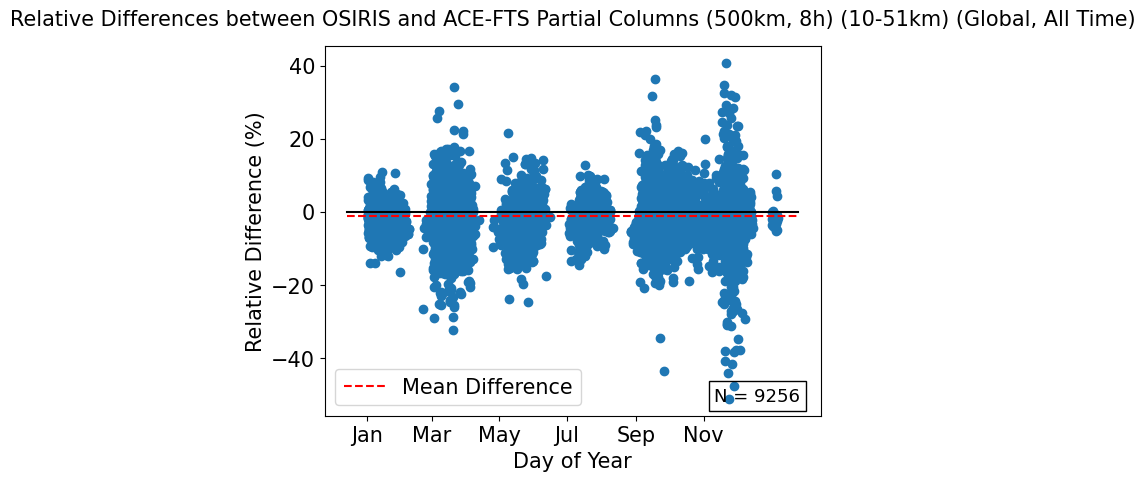

In [109]:
plt.scatter(days_of_year, rel)
rel_mean = np.nanmean(rel)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Relative Difference (%)")
plt.title("Relative Differences between OSIRIS and ACE-FTS Partial Columns" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)
locs  = np.array([0,  58, 118, 178, 240, 300])
ticks = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]
plt.xticks(locs, ticks)

plt.legend()
fig = plt.gcf()
axes = plt.gca()

plt.text(0.785, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [110]:
o3L_std = np.nanstd(o3L_coincidences)
o3S_std = np.nanstd(o3S_coincidences)
o3L_mean = np.nanmean(o3L_coincidences)
o3S_mean = np.nanmean(o3S_coincidences)

L_minus_mean = (o3L_coincidences - o3L_mean)
S_minus_mean = (o3S_coincidences - o3S_mean)

summing = np.nansum((L_minus_mean / o3L_std) * (S_minus_mean / o3S_std)) / (len(L_minus_mean) - 1)

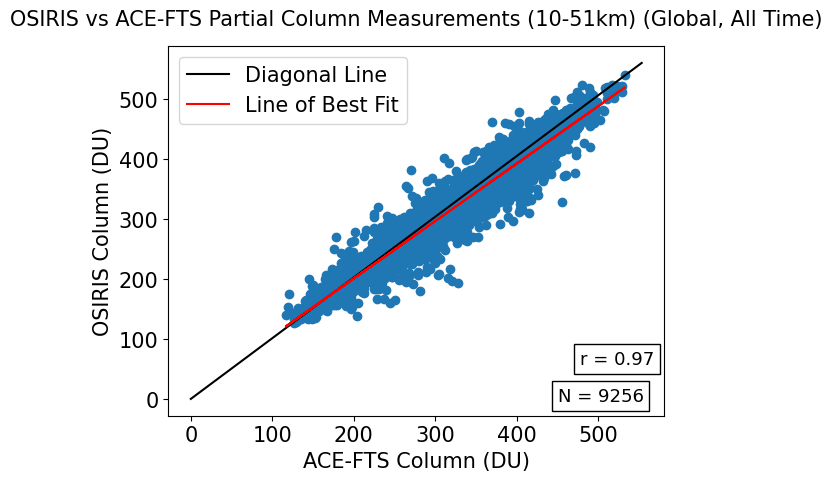

In [111]:
plt.scatter(o3S_coincidences, o3L_coincidences, color = "C0")
plt.xlabel("ACE-FTS Column (DU)")
plt.ylabel("OSIRIS Column (DU)")
# plt.title("OSIRIS vs ACE-FTS Partial Column Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)
plt.title("OSIRIS vs ACE-FTS Partial Column Measurements" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot([0, xlims[1]], [0, ylims[1]], color = "black", label = "Diagonal Line")

mask = np.isfinite(o3L_coincidences) & np.isfinite(o3S_coincidences)
o3L_coincidences_nonan = o3L_coincidences[mask]
o3S_coincidences_nonan = o3S_coincidences[mask]

slope, intercept = np.polyfit(o3S_coincidences_nonan, o3L_coincidences_nonan, 1)
line = slope * o3S_coincidences + intercept
plt.plot(o3S_coincidences, line, color = "red", label = "Line of Best Fit")
plt.legend()

fig = plt.gcf()
axes = plt.gca()

plt.text(0.785, 0.04, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.830, 0.14, f"r = {summing:.2f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [112]:
import os

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg'}

def count_images(root_folder):
    count = 0
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for fname in filenames:
            ext = os.path.splitext(fname)[1].lower()
            if ext in IMAGE_EXTENSIONS:
                count += 1
    return count

if __name__ == '__main__':
    folder = R'C:\Users\salla\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\O3_ANALYSIS'
    total_images = count_images(folder)
    print(f'Total image files (recursively) in "{folder}": {total_images}')


Total image files (recursively) in "C:\Users\salla\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\O3_ANALYSIS": 282


C:\Users\salla\AppData\Local\Temp\ipykernel_10756\872146623.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))


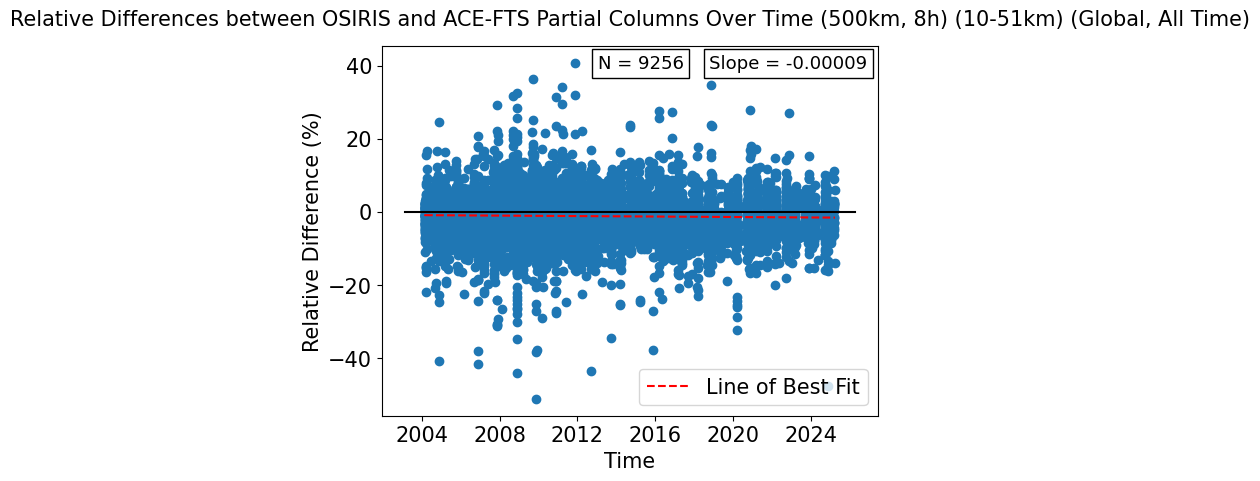

In [113]:
import matplotlib.dates as mdates
import pandas as pd
time_ordinal = mdates.date2num(pd.to_datetime(time))
# time_ordinal = np.array(time).astype('datetime64[ns]').astype(np.int64)
plt.scatter(time_ordinal, rel)
# rel_mean = np.nanmean(rel)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")

rel_is_nan = np.isnan(rel[:,0])
nonan_rel = rel[~rel_is_nan]
nonan_time_ordinal = time_ordinal[~rel_is_nan]
nonan_time = np.array(time)[~rel_is_nan]

slope, intercept = np.polyfit(nonan_time_ordinal, nonan_rel, 1)
line = slope * nonan_time_ordinal + intercept
plt.plot(nonan_time, line, color = "red", label = "Line of Best Fit", linestyle = "dashed")

# plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Time")
plt.ylabel("Relative Difference (%)")
plt.title("Relative Differences between OSIRIS and ACE-FTS Partial Columns Over Time" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend(loc = "lower right")
fig = plt.gcf()
axes = plt.gca()

plt.text(0.435, 0.94, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_10756\1404461340.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))


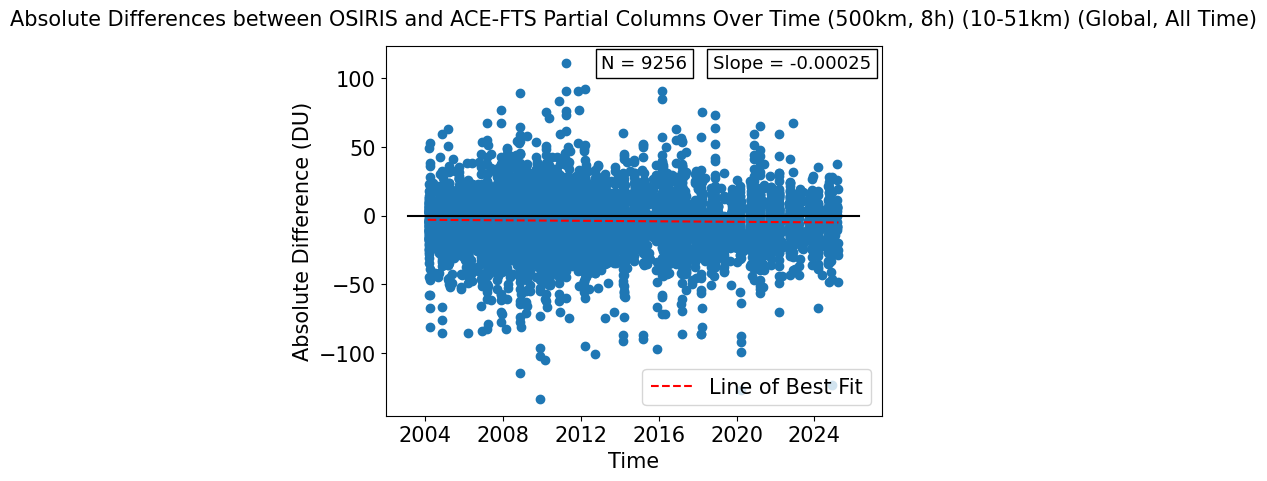

In [114]:
import matplotlib.dates as mdates
import pandas as pd
time_ordinal = mdates.date2num(pd.to_datetime(time))
# time_ordinal = np.array(time).astype('datetime64[ns]').astype(np.int64)
plt.scatter(time_ordinal, raw)
# rel_mean = np.nanmean(raw)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")

raw_is_nan = np.isnan(raw[:,0])
nonan_rel = raw[~raw_is_nan]
nonan_time_ordinal = time_ordinal[~raw_is_nan]
nonan_time = np.array(time)[~raw_is_nan]

slope, intercept = np.polyfit(nonan_time_ordinal, nonan_rel, 1)
line = slope * nonan_time_ordinal + intercept
plt.plot(nonan_time, line, color = "red", label = "Line of Best Fit", linestyle = "dashed")

# plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Time")
plt.ylabel("Absolute Difference (DU)")
plt.title("Absolute Differences between OSIRIS and ACE-FTS Partial Columns Over Time" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend(loc = "lower right")
fig = plt.gcf()
axes = plt.gca()

plt.text(0.435, 0.94, f"N = {len(o3L_coincidences)}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [115]:
import seasonal_columns_helper

seasonal_months = {"DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11]}

seasonalhelper = seasonal_columns_helper.SeasonalHelper(measurement_times, o3S_coincidences, o3L_coincidences)

o3S_seasonal_coincidences = seasonalhelper.seasonal_coincidences1()

o3L_seasonal_coincidences = seasonalhelper.seasonal_coincidences2()

o3S_seasonal_coincidences_times = seasonalhelper.seasonal_times()

n_seasonal_coincidences = seasonalhelper.seasonal_coincidences_count()

no_seasonal_coincidences = seasonalhelper.empty_seasons()

In [116]:
rel_seasonal = {season: compute_diffs(o3L_seasonal_coincidences[season], o3S_seasonal_coincidences[season])[0] for season in seasonal_months}

abs_seasonal = {season: compute_diffs(o3L_seasonal_coincidences[season], o3S_seasonal_coincidences[season])[1] for season in seasonal_months}

rel_diffs_seasonal = {season: np.nanmean(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

rel_std_seasonal = {season: np.nanstd(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

abs_diffs_seasonal = {season: np.nanmean(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

abs_std_seasonal = {season: np.nanstd(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

o3L_std_seasonal = {season: np.nanstd(season_coincidences) for season, season_coincidences in o3L_seasonal_coincidences.items()}
o3S_std_seasonal = {season: np.nanstd(season_coincidences) for season, season_coincidences in o3S_seasonal_coincidences.items()}
o3L_mean_seasonal = {season: np.nanmean(season_coincidences) for season, season_coincidences in o3L_seasonal_coincidences.items()}
o3S_mean_seasonal = {season: np.nanmean(season_coincidences) for season, season_coincidences in o3S_seasonal_coincidences.items()}

L_minus_mean_seasonal = {season: (o3L_seasonal_coincidences[season] - o3L_mean_seasonal[season]) for season in seasonal_months}
S_minus_mean_seasonal = {season: (o3S_seasonal_coincidences[season] - o3S_mean_seasonal[season]) for season in seasonal_months}

summing_seasonal = {
    season: np.nansum(
        (L_minus_mean_seasonal[season] / o3L_std_seasonal[season]) * (S_minus_mean_seasonal[season] / o3S_std_seasonal[season]) 
    ) / (len(L_minus_mean_seasonal[season]) - 1)
    for season in seasonal_months
}

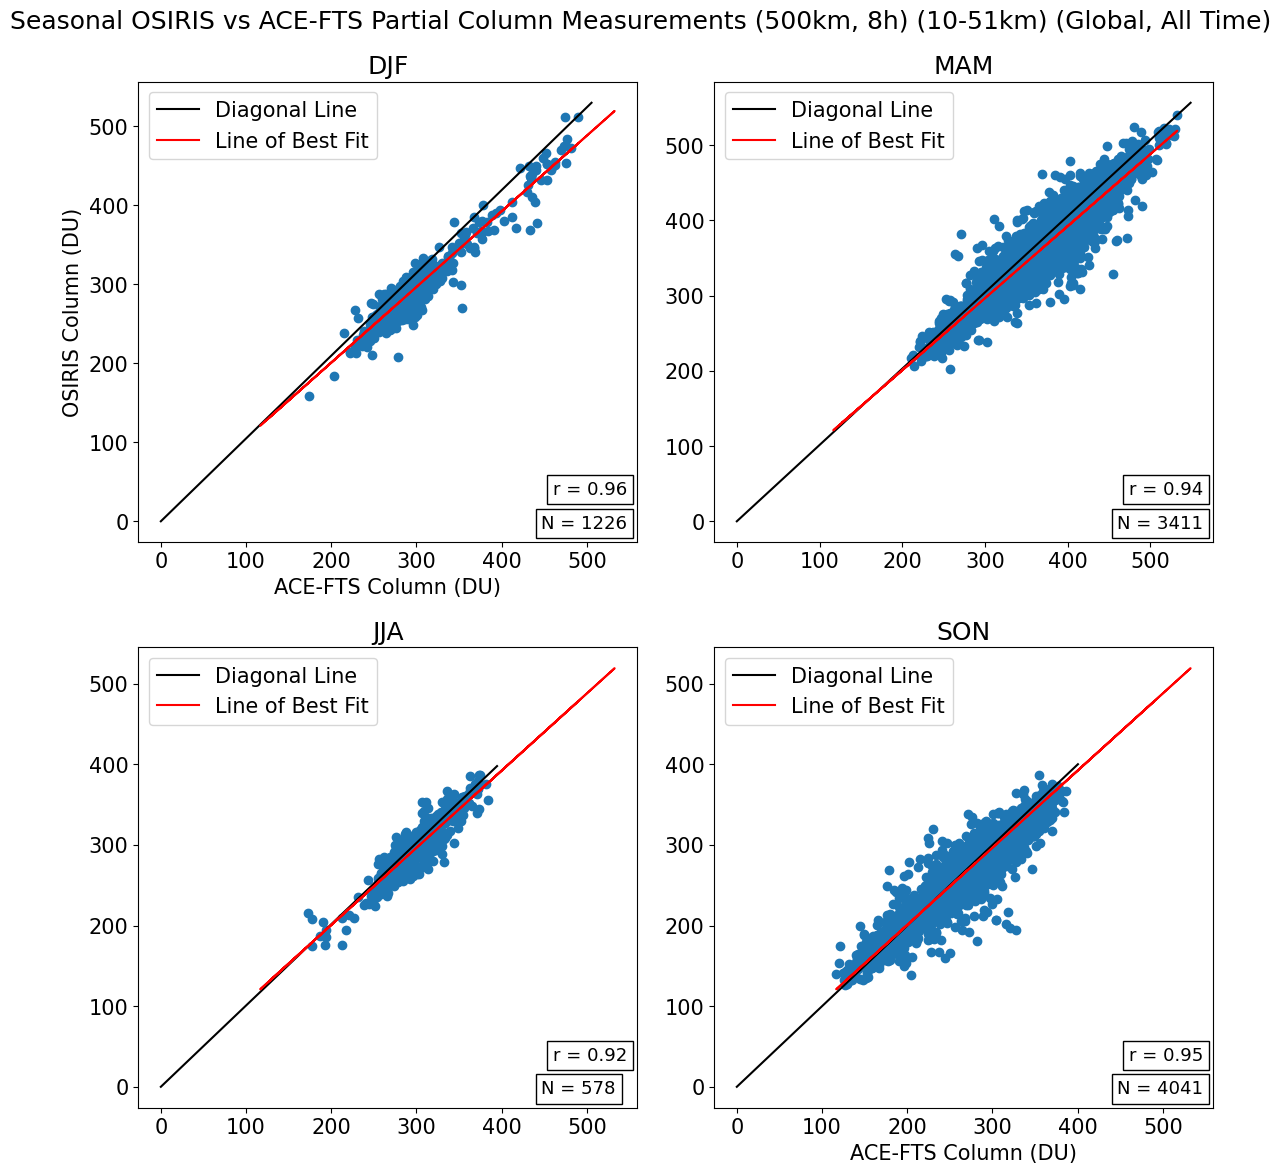

In [117]:
fig, axes = plt.subplots(2,2, figsize = (12,12))
for i, season in enumerate(seasonal_months):
    ax = axes.flat[i]
    ax.scatter(o3S_seasonal_coincidences[season], o3L_seasonal_coincidences[season])
    ax.set_title(season)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    ax.plot([0, xmax], [0, ymax], color = "black", label = "Diagonal Line")

    slope, intercept = np.polyfit(o3S_coincidences_nonan, o3L_coincidences_nonan, 1)
    line = slope * o3S_coincidences + intercept
    ax.plot(o3S_coincidences, line, color = "red", label = "Line of Best Fit")

    ax.text(0.808, 0.03, f"N = {len(o3L_seasonal_coincidences[season])}", fontsize=13, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
    ax.text(0.831, 0.103, f"r = {summing_seasonal[season]:.2f}", fontsize=13, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    ax.legend()
    
    if season in no_seasonal_coincidences:
        ax.set_visible(False)



axes[0, 0].set_ylabel("OSIRIS Column (DU)")
axes[0, 0].set_xlabel("ACE-FTS Column (DU)")
axes[1, 1].set_xlabel("ACE-FTS Column (DU)")

plt.suptitle("Seasonal OSIRIS vs ACE-FTS Partial Column Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (Global, All Time)", fontdict = {'fontsize': 15})

fig.tight_layout()

In [118]:
rel

array([[ -1.4873922],
       [ -4.6142306],
       [ -3.5979385],
       ...,
       [ -6.422403 ],
       [  6.027982 ],
       [-14.086235 ]], dtype=float32)

In [119]:
rel[:,0]

array([ -1.4873922,  -4.6142306,  -3.5979385, ...,  -6.422403 ,
         6.027982 , -14.086235 ], dtype=float32)